# BrainTrust Classification Tutorial (Article Titles)

<a target="_blank" href="https://colab.research.google.com/github/braintrustdata/braintrust-examples/blob/main/classify/python/BrainTrust-Classify-Tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Welcome to [BrainTrust](https://www.braintrustdata.com/)! This is a quick tutorial on how to build and evaluate an AI app to classify news titles into categories.

Before starting, make sure that you have a BrainTrust account. If you do not, please [sign up](https://www.braintrustdata.com) or [get in touch](mailto:info@braintrustdata.com). After this tutorial, learn more by visiting [the docs](http://www.braintrustdata.com/docs).

In [ ]:
# NOTE: Replace YOUR_OPENAI_KEY with your OpenAI API Key and YOUR_BRAINTRUST_API_KEY with your BrainTrust API key. Do not put it in quotes.
%env OPENAI_API_KEY=YOUR_OPENAI_KEY
%env BRAINTRUST_API_KEY=YOUR_BRAINTRUST_API_KEY

First, we'll install some dependencies.

In [ ]:
%pip install braintrust guidance openai datasets autoevals

Next, we'll import the [ag_news dataset](https://huggingface.co/datasets/ag_news) from Huggingface.

In [ ]:
import asyncio
import braintrust
import time

from datasets import load_dataset

# Load dataset from Huggingface.
dataset = load_dataset("ag_news", split="train")

# Shuffle and trim to 20 datapoints. Restructure our dataset
# slightly so that each item in the list contains the title
# itself ("text") and the expected category index ("label").
trimmed_dataset = dataset.shuffle(seed=42)[:20]
articles = [{
    "text": trimmed_dataset["text"][i],
    "label": trimmed_dataset["label"][i],
    } for i in range(len(trimmed_dataset["text"]))]

# Extract category names from the dataset and build a map from index to
# category name. We will use this to compare the expected categories to
# those produced by the model.
category_names = dataset.features['label'].names
category_map = dict([name for name in enumerate(category_names)])
valid_categories = set(x.strip().lower() for x in category_map.values())

## Writing the initial prompts

Let's first write a prompt for categorizing a title for just one article. With BrainTrust, you can use any library you'd like -- Guidance, LangChain, or even just direct calls to an LLM.

The prompt provides the article's title to the model, and asks it to generate a category.

In [ ]:
test_article = articles[0]
test_label = test_article["label"]
test_text = test_article["text"]

print("Article Text:",test_text)
print("Article Label:",test_label)
print("Category:", category_map[test_label])

In [ ]:
import openai
MODEL = "gpt-3.5-turbo"

def classify_article(article_title):
    messages = [
        {
            "role": "system",
            "content": """You are an editor in a newspaper who helps writers identify the right category for their news articles,
by reading the article's title. The category should be one of the following: World, Sports, Business or Sci-Tech. Reply with one word corresponding to the category."""},
        {
            "role": "user",
            "content": "Article title: {article_title} Category:".format(article_title=article_title)
        },]
    result = openai.ChatCompletion.create(
        model=MODEL,
        messages=messages,
        max_tokens=10,
    )
    category = result.choices[0].message.content
    return (result, category)

result, test_classify = classify_article(test_text)
print("Classified as:", test_classify)
print("Score:", 1 if test_classify == category_map[test_label] else 0)

## Running across the dataset

Now that we have automated classifying titles, we can test the full set of articles. This block uses Python's async features to generate and grade in parallel.

As it runs, we compare the generated category to the expected one from the dataset. Once this loop completes, you can view the results in BrainTrust.

In [ ]:
async def evaluate_article(article, classifyFn):
  full_output, category = classifyFn(article_title=article["text"])
  category = category.strip().lower()
  expected = category_map[article["label"]].strip().lower()
  return (article, full_output, expected, category)


async def run_on_all_articles(classifyFn):
    start = time.time()
    tasks = [asyncio.create_task(evaluate_article(article, classifyFn)) for article in articles]
    category_grades = [await t for t in tasks]
    end = time.time()
    print("Took", end - start, "seconds")
    return category_grades

def analyze_experiment(categories, experiment):
  for (article, full_output, expected, category) in categories:
    experiment.log(
        inputs={"title": article["text"]},
        output=category,
        expected=expected,
        scores={
            "match": 1 if category == expected else 0,
            "valid": 1 if category in valid_categories else 0,
        },
        metadata={
           "prompt": str(full_output)
        }
    )

In [ ]:
# Initialize a new experiment.
experiment = braintrust.init(
  project="classify-article-titles",
  experiment="original-prompt"
)

categories = await run_on_all_articles(classify_article)

analyze_experiment(categories, experiment)

print(experiment.summarize())

## Pause and analyze the results in BrainTrust!

The cell above will print a link to the BrainTrust experiment. Click on it to investigate where we can improve our AI app.


Looking at our results table, we incorrectly output `sci-tech` instead of `sci/tech` which results in a failed eval test case. Let's fix it.

![CleanShot 2023-08-29 at 13.58.14@2x.png](<attachment:CleanShot 2023-08-29 at 13.58.14@2x.png>)

## Reproducing an example

First, let's see if we can reproduce this issue locally. We can test an article corresponding to the "Sci/Tech" category and reproduce the evaluation:
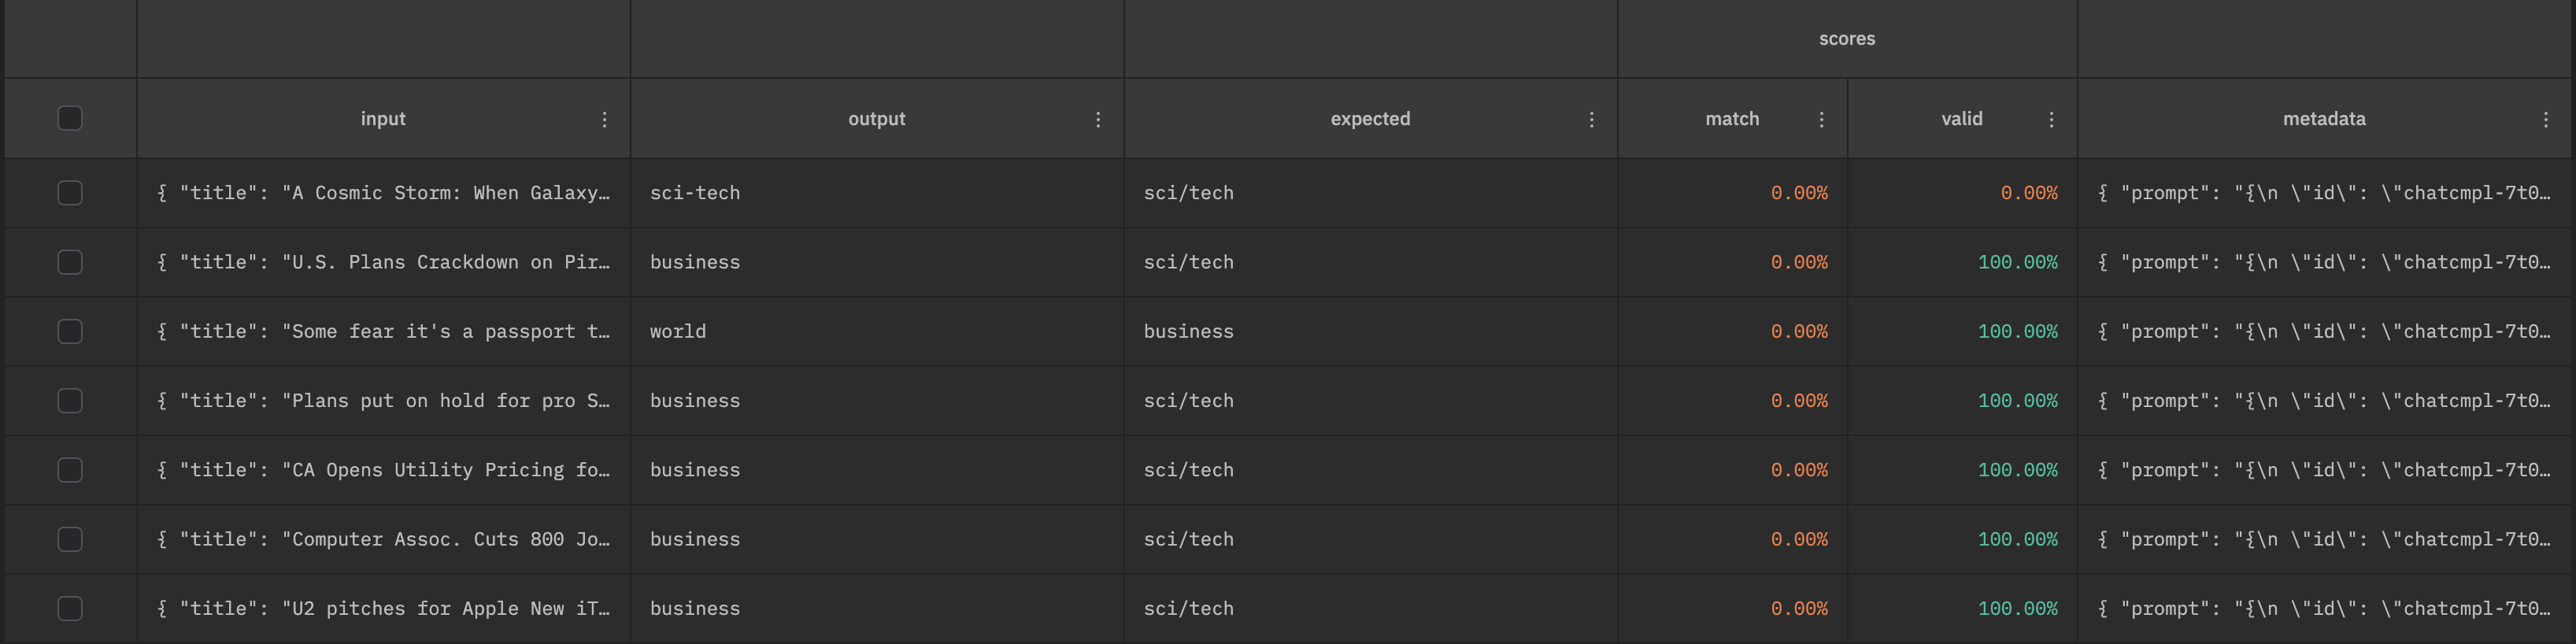

In [ ]:
sci_tech_article = [a for a in articles if "Galaxy Clusters" in a["text"]][0]
print(sci_tech_article["text"])
print(sci_tech_article["label"])

out = classify_article(article_title=sci_tech_article["text"])
print(out)

### Fixing the prompt

Have you spotted the issue? We have mispelled one of the categories in our prompt. The dataset's categories are "World, Sports, Business and *Sci/Tech*" - but we are using *Sci-Tech* in our prompt. Let's fix it:

In [ ]:
def classify_article_2(article_title):
    messages = [
        {
            "role": "system",
            "content": """You are an editor in a newspaper who helps writers identify the right category for their news articles,
by reading the article's title. The category should be one of the following: World, Sports, Business or Sci/Tech. Reply with one word corresponding to the category."""},
        {
            "role": "user",
            "content": "Article title: {article_title} Category:".format(article_title=article_title)
        },]
    result = openai.ChatCompletion.create(
        model=MODEL,
        messages=messages,
        max_tokens=10,
    )
    category = result.choices[0].message.content
    return (result, category)

result, test_classify = classify_article_2(article_title=sci_tech_article["text"])

print(test_classify)

### Evaluate the new prompt

The model classified the correct category `Sci/Tech` for this example. But, how do we know it works for the rest of the dataset? Let's run a new experiment to evaluate our new prompt using BrainTrust.

In [ ]:
# Initialize a new experiment.
experiment = braintrust.init(
  project="classify-article-titles",
  experiment="fixed-sci-tech-prompt"
)

categories = await run_on_all_articles(classify_article_2)

analyze_experiment(categories, experiment)

print(experiment.summarize())

## Conclusion

Click into the new experiment, and check it out! You should notice a few things:

![Compare](compare.png)

* BrainTrust will automatically compare the new experiment to your previous one.
* You should the eval scores increase and you can see which test cases improved.
* You can also filter the test cases that have a low score and work on improving the prompt for those

Now, you are on your journey of building reliable AI apps with BrainTrust.

Learn more on our docs @ [https://www.braintrustdata.com/docs](https://www.braintrustdata.com/docs).